In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # for google colab. adjust accordingly
PARENT_DIR = '/content/drive/MyDrive/CS287-final-project/' # for google colab. adjust accordingly

Mounted at /content/drive


In [ ]:
#check gpu connection
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 21 15:52:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#check high-ram connection
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# process data, tatoeba project

In [ ]:
#tatoeba dataset
#source: http://www.manythings.org/anki/
#downloaded 'fra-eng.zip' file

# #load full data
# tatoeba_df = pd.read_csv(f'{PARENT_DIR}tatoeba/fra.txt', sep='\t', header=None)
# #take a random subset
# n_sentences_total = tatoeba_df.shape[0]
# start = int((n_sentences_total/20)*19) #sample from the last chunk of data because early sentences are very short
# end = n_sentences_total
# tatoeba_df_subset = tatoeba_df.iloc[start:end, :].sample(n=2500, random_state=12345, axis='index')

# #save random subset
# tatoeba_df_subset.to_pickle(f'{PARENT_DIR}tatoeba/tatoeba_df_subset.pkl')

#load random subset
tatoeba_df_subset = pd.read_pickle(f'{PARENT_DIR}tatoeba/tatoeba_df_subset.pkl')

## source: english

english, #sentences: 2500
english, #words in shortest sentence: 6
english, #words in longest sentence: 34
english, average #words in sentence: 12.4808


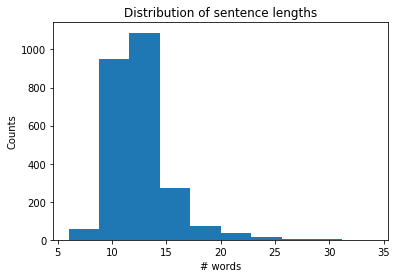

In [ ]:
#source language
tatoeba_en = list(tatoeba_df_subset[0])

#examine dataset
tatoeba_en_sentence_lengths = [len(sentence.split()) for sentence in tatoeba_en]
tatoeba_len_longest_sentence = max(tatoeba_en_sentence_lengths) #used as argument when getting topk translations
print('english, #sentences:', len(tatoeba_en))
print('english, #words in shortest sentence:', min(tatoeba_en_sentence_lengths))
print('english, #words in longest sentence:', max(tatoeba_en_sentence_lengths))
print('english, average #words in sentence:', np.mean(tatoeba_en_sentence_lengths))

plt.hist(tatoeba_en_sentence_lengths)
plt.title('Distribution of sentence lengths')
plt.xlabel('# words')
plt.ylabel('Counts');

In [ ]:
#add conditioning in front of each sentence
tatoeba_en = ['translate English to French: ' + sentence for sentence in tatoeba_en]
display(tatoeba_en[0:10])

['translate English to French: It is difficult to get him to do anything on the spur of the moment.',
 "translate English to French: I'd rather clean my room than spend time doing my homework.",
 'translate English to French: We desperately need more money to help fund our project.',
 'translate English to French: If you want me to help you, all you have to do is ask.',
 'translate English to French: The world was on the very brink of nuclear war during the Cuban Missile Crisis in October 1962.',
 'translate English to French: The president is expected to put forward a new energy policy.',
 'translate English to French: I planted various fruit trees on my property three years ago.',
 "translate English to French: I honestly think it's better to be a failure at something you love than to be a success at something you hate.",
 'translate English to French: If you tell a lie enough times, you begin to believe it.',
 "translate English to French: I would've told you before, but I didn't th

In [ ]:
#batch dataset: create a list of lists
n_sentences = len(tatoeba_en)
batch_size = 1
n_batches = n_sentences/batch_size
tatoeba_en_batched = np.array_split(tatoeba_en, n_batches) #creates list of 100 arrays
tatoeba_en_batched = list(map(list, tatoeba_en_batched)) #now have list of 100 lists

#print head
tatoeba_en_batched[0:3]

[['translate English to French: It is difficult to get him to do anything on the spur of the moment.'],
 ["translate English to French: I'd rather clean my room than spend time doing my homework."],
 ['translate English to French: We desperately need more money to help fund our project.']]

## reference: french

french, #sentences: 2500
french, #words in shortest sentence: 6
french, #words in longest sentence: 47
french, average #words in sentence: 13.2272


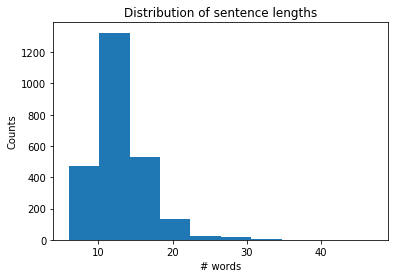

In [ ]:
#reference language
tatoeba_fr = list(tatoeba_df_subset[1])

#examine dataset
tatoeba_fr_sentence_lengths = [len(sentence.split()) for sentence in tatoeba_fr]

print('french, #sentences:', len(tatoeba_fr))
print('french, #words in shortest sentence:', min(tatoeba_fr_sentence_lengths))
print('french, #words in longest sentence:', max(tatoeba_fr_sentence_lengths))
print('french, average #words in sentence:', np.mean(tatoeba_fr_sentence_lengths))

plt.hist(tatoeba_fr_sentence_lengths)
plt.title('Distribution of sentence lengths')
plt.xlabel('# words')
plt.ylabel('Counts');

## calculate BLEU scores

In [ ]:
from torchtext.data.metrics import bleu_score

In [ ]:
def calc_bleu_score(translations, references):
    translations_formatted = [translation.split() for translation in translations]
    references_formatted = [[translation.split()] for translation in references]
    return bleu_score(translations_formatted, references_formatted)

In [ ]:

# print('greedy:', calc_bleu_score(translations=tatoeba_enfr_greedy, references=tatoeba_fr))
# print('beam, beam5, top1:', calc_bleu_score(translations=tatoeba_enfr_beam_beam5_top1, references=tatoeba_fr))
# print('top-k sampling, k=20, top1:', calc_bleu_score(translations=tatoeba_enfr_topk_k20_top1, references=tatoeba_fr))
# print('top-k sampling, k=50, top1:', calc_bleu_score(translations=tatoeba_enfr_topk_k50_top1, references=tatoeba_fr))
# print('ancestral sampling, top1:', calc_bleu_score(translations=tatoeba_enfr_ancestral_top1, references=tatoeba_fr))
# print('nucleus sampling, p=0.50, top1:', calc_bleu_score(translations=tatoeba_enfr_nucleus_p50_top1, references=tatoeba_fr))
# print('nucleus sampling, p=0.90, top1:', calc_bleu_score(translations=tatoeba_enfr_nucleus_p90_top1, references=tatoeba_fr))


greedy: 0.37735436171414116
beam, beam5, top1: 0.39751948518368896
top-k sampling, k=20, top1: 0.2056148797273636
top-k sampling, k=50, top1: 0.19476744532585144
ancestral sampling, top1: 0.17997339367866516
nucleus sampling, p=0.50, top1: 0.36389776091588677
nucleus sampling, p=0.90, top1: 0.2452133744955063


In [ ]:
def calc_bleu_score_from_file(filename):
  with open(f'/content/drive/MyDrive/CS287-final-project/MBR/{filename}') as file:
      translations = file.readlines()

  return calc_bleu_score(translations=translations, references=tatoeba_fr)


In [ ]:
#print(calc_bleu_score_from_file(filename='beam_beam5_translations.txt'))
#print(calc_bleu_score_from_file(filename='basic_candidates_topk_k10_n400_translations.txt'))
#print(calc_bleu_score_from_file(filename='basic_candidates_topp_p70_n400_translations.txt'))

# all with n = 200 samples and C2F decoding
print('Ancestral + MBR with candidates = 1000', calc_bleu_score_from_file(filename='samples_ancestral_n200_basic_candidates_ancestral_n1000_translations.txt'))
print('Beam + MBR with beam_size = 5', calc_bleu_score_from_file(filename='samples_ancestral_n200_basic_candidates_beam_beam5_translations.txt'))
print('Top-K + MBR with k = 10, n = 400', calc_bleu_score_from_file(filename='samples_ancestral_n200_basic_candidates_topk_k10_n400_translations.txt'))
print('Top-p + MBR with p = 70, n = 400', calc_bleu_score_from_file(filename='samples_ancestral_n200_basic_candidates_topp_p70_n400_translations.txt'))



Ancestral + MBR with candidates = 1000 0.39348789175529625
Beam + MBR with beam_size = 5 0.39716769512235695
Top-K + MBR with k = 10, n = 400 0.3917535408110421
Top-p + MBR with p = 70, n = 400 0.39253676508230795


In [ ]:
def translation_lengths_from_file(filename):
  with open(f'/content/drive/MyDrive/CS287-final-project/{filename}') as file:
      translations = file.readlines()
  
  return [len(s.split()) for s in translations]


beam          13.1012
beam + MBR    13.0484
topk + MBR    13.0484
dtype: float64

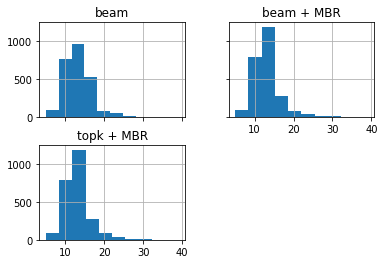

In [ ]:
df = pd.DataFrame({'beam' : translation_lengths_from_file(filename='topk_translations/tatoeba_enfr_beam_beam5_top1.txt'),
                   'beam + MBR' : translation_lengths_from_file(filename='MBR/beam_beam5_translations.txt'), 
                   'topk + MBR' : translation_lengths_from_file(filename='MBR/beam_beam5_translations.txt')})
df.hist(sharex=True, sharey=True)
df.mean()
#g = sns.FacetGrid(tips, col="time",  row="sex")
#g.map(sns.scatterplot, "total_bill", "tip")

12.9752


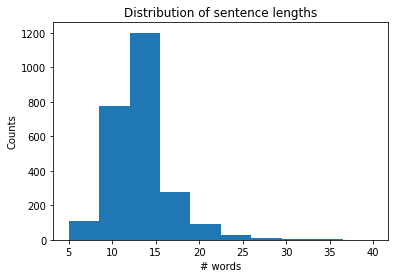

In [ ]:
lengths = avg_length_from_file(filename='samples_ancestral_n200_basic_candidates_topp_p70_n400_translations.txt')

plt.hist(lengths)
plt.title('Distribution of sentence lengths')
plt.xlabel('# words')
plt.ylabel('Counts');
print(np.mean(lengths))

13.0484


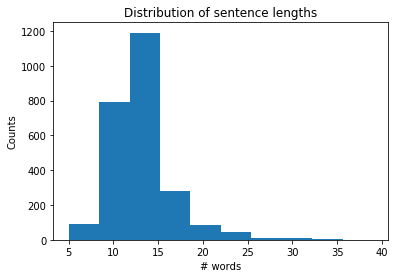

In [ ]:
lengths = avg_length_from_file(filename='beam_beam5_translations.txt')

plt.hist(lengths)
plt.title('Distribution of sentence lengths')
plt.xlabel('# words')
plt.ylabel('Counts');
print(np.mean(lengths))